# LASSO问题的求解

LASSO（Least Absolute Shrinkage and Selection Operator，最小绝对收缩和选择算子）模型是一种线性回归分析方法，主要用于变量选择和正则化：
$$
\min_{x\in {\mathbb R}^n}\frac12 \|Ax-b\|_2^2+\lambda\|x\|_1
$$
其中数据矩阵$A\in {\mathbb R}^{m\times n}$, 观察向量$b\in {\mathbb R}^n$， 正则参数$\lambda>0$.

参考文献

[1] 叶颀, 谭露琳, 刘春光, 林荣荣，陈艳楠, 胡耀华.《最优化方法与机器学习》, 科学出版社“十四五”普通高等教育规划教材, 2025，第5.2.4节

# 目录

1. 模拟的数据集

2. ISTA 

3. FISTA

4. BB-ISTA

5. ADMM

6. 练习

7. 拓展

# 1 模拟的数据集

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error

rcParams['font.sans-serif'] = ['SimHei']  
rcParams['axes.unicode_minus'] = False  
rcParams['figure.dpi'] = 400 

def generate_data(n_samples, n_features, sparsity, noise_level):
    np.random.seed(0)
    A = np.random.randn(n_samples, n_features)
    true_coef = np.zeros(n_features)
    indices = np.random.choice(n_features, sparsity, replace=False)
    true_coef[indices] = np.random.randn(sparsity) * 5 
    b = A @ true_coef + noise_level * np.random.randn(n_samples)
    return A, b, true_coef

# 2 ISTA

Iterative Shrinkage and Thresholding Algorithm(ISTA)
$$
x^{k+1}=prox_{\mu\lambda \|\cdot\|_1}(x^k-\mu A^T(Ax^k-b))=prox_{\mu\lambda \|\cdot\|_1}((I-\mu A^TA)x^k+\mu A^T b)
$$
其中$\mu$不超过A^TA的最大特征值分之二.

In [18]:
def ista(A, b, lambda_, mu, max_iter=100, tol=1e-6):
    x = np.zeros(A.shape[1])
    cost_history = []
    mse_history = []
    
    for i in range(max_iter):
        gradient = A.T @ (A @ x - b)
        x_temp = x - mu * gradient
        x = np.sign(x_temp) * np.maximum(np.abs(x_temp) - mu * lambda_, 0)
        cost = 0.5 * np.linalg.norm(b - A @ x) ** 2 + lambda_ * np.sum(np.abs(x))
        mse = mean_squared_error(true_coef, x)
        
        cost_history.append(cost)
        mse_history.append(mse)
        
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            break
    return x, cost_history, mse_history

# 3 FISTA

Faster Iterative Shrinkage and Thresholding Algorithm (FISTA)
$$
x^{k}=prox_{\mu\lambda \|\cdot\|_1}((I-\mu A^TA)y^k+\mu A^T b)
$$
$$
t_{k+1}=\frac{1+\sqrt{1+4 t_k^2}}{2}
$$
$$
y^{k+1}=x^k+\frac{t_k-1}{t_{k+1}}(x^k-x^{k-1})
$$
其中$\mu$不超过A^TA的最大特征值分之二, $t_1=1$, $y^1=x^0$.

In [19]:
def fista(A, b, lambda_, mu, max_iter=100, tol=1e-6):
    x = np.zeros(A.shape[1])
    x_old = x.copy()
    t = 1
    cost_history = []
    mse_history = []
    
    for i in range(max_iter):
        gradient = A.T @ (A @ x - b)
        x_temp = x - mu * gradient
        x_new = np.sign(x_temp) * np.maximum(np.abs(x_temp) - mu * lambda_, 0)
        
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        x = x_new + ((t - 1) / t_new) * (x_new - x_old)
        
        x_old = x_new
        t = t_new
        
        cost = 0.5 * np.linalg.norm(b - A @ x) ** 2 + lambda_ * np.sum(np.abs(x))
        mse = mean_squared_error(true_coef, x)
        
        cost_history.append(cost)
        mse_history.append(mse)
        
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            break
    return x, cost_history, mse_history

# 4 BB-ISTA

BB-ISTA: 在ISTA中用Barzilai-Borwein (BB)自适应步长
$$
x^{k+1}=prox_{\mu^k \lambda \|\cdot\|_1}((I-\mu^k A^TA)x^k+\mu^k A^T b)
$$
$$
\mu^k=\frac{(x^k-x^{k-1})^T(x^k-x^{k-1})}{(x^k-x^{k-1})^T A^TA (x^k-x^{k-1})}
$$

In [20]:
def BBista(A, b, lambda_, mu, max_iter=100, tol=1e-6):
    x = np.zeros(A.shape[1])
    cost_history = []
    mse_history = []
    x_old = x.copy()
        
    for i in range(max_iter):
        gradient = A.T @ (A @ x - b)
        x_temp = x - mu * gradient
        x = np.sign(x_temp) * np.maximum(np.abs(x_temp) - mu * lambda_, 0)
       
        mu=(np.linalg.norm(x-x_old,2)/np.linalg.norm(A@(x-x_old),2))**2
        
        x_old = x.copy()
        cost = 0.5 * np.linalg.norm(b - A @ x) ** 2 + lambda_ * np.sum(np.abs(x))
        mse = mean_squared_error(true_coef, x)
        
        cost_history.append(cost)
        mse_history.append(mse)
        
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            break
    return x, cost_history, mse_history

# 5 ADMM

$$
x^{k+1}=(A^TA+\rho I)^{-1}(A^Tb+\rho y^k-z^k)
$$
$$
y^{k+1}=prox_{\frac{\lambda}{\rho}\|\cdot\|_1}(x^{k+1}+\frac{z^k}{\rho})
$$
$$
z^{k+1}=z^k+\tau\rho(x^{k+1}-y^{k+1})
$$
其中$0<\tau<\frac{\sqrt{5}+1}{2}$.

In [21]:
def soft_thresholding(x, alpha):
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)

def admm_lasso(A, b, lambda_, rho=1,tau=1.618, max_iter=100, tol=1e-6):
    n = A.shape[1]
    x = np.zeros(n)
    y = np.zeros(n)
    z =np.zeros(n)
    cost_history = []
    mse_history = []
    # 预计算 (A^T A + rho * I) 的逆
    inv_matrix = np.linalg.inv(A.T @ A + rho * np.eye(n))
    
    for i in range(max_iter):
        # 更新 x
        x = inv_matrix @ (A.T @ b + rho * y - z)
        
        # 更新 y
        y = soft_thresholding(x + z/rho,lambda_ / rho)
        
        # 更新 z
        z = z + tau*rho*(x - z)
    
        cost = 0.5 * np.linalg.norm(b - A @ x) ** 2 + lambda_ * np.sum(np.abs(x))
        mse = mean_squared_error(true_coef, x)
         
        cost_history.append(cost)
        mse_history.append(mse)
        
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            break
    return x, cost_history, mse_history

# 求解LASSO问题的四种算法的数值结果比较

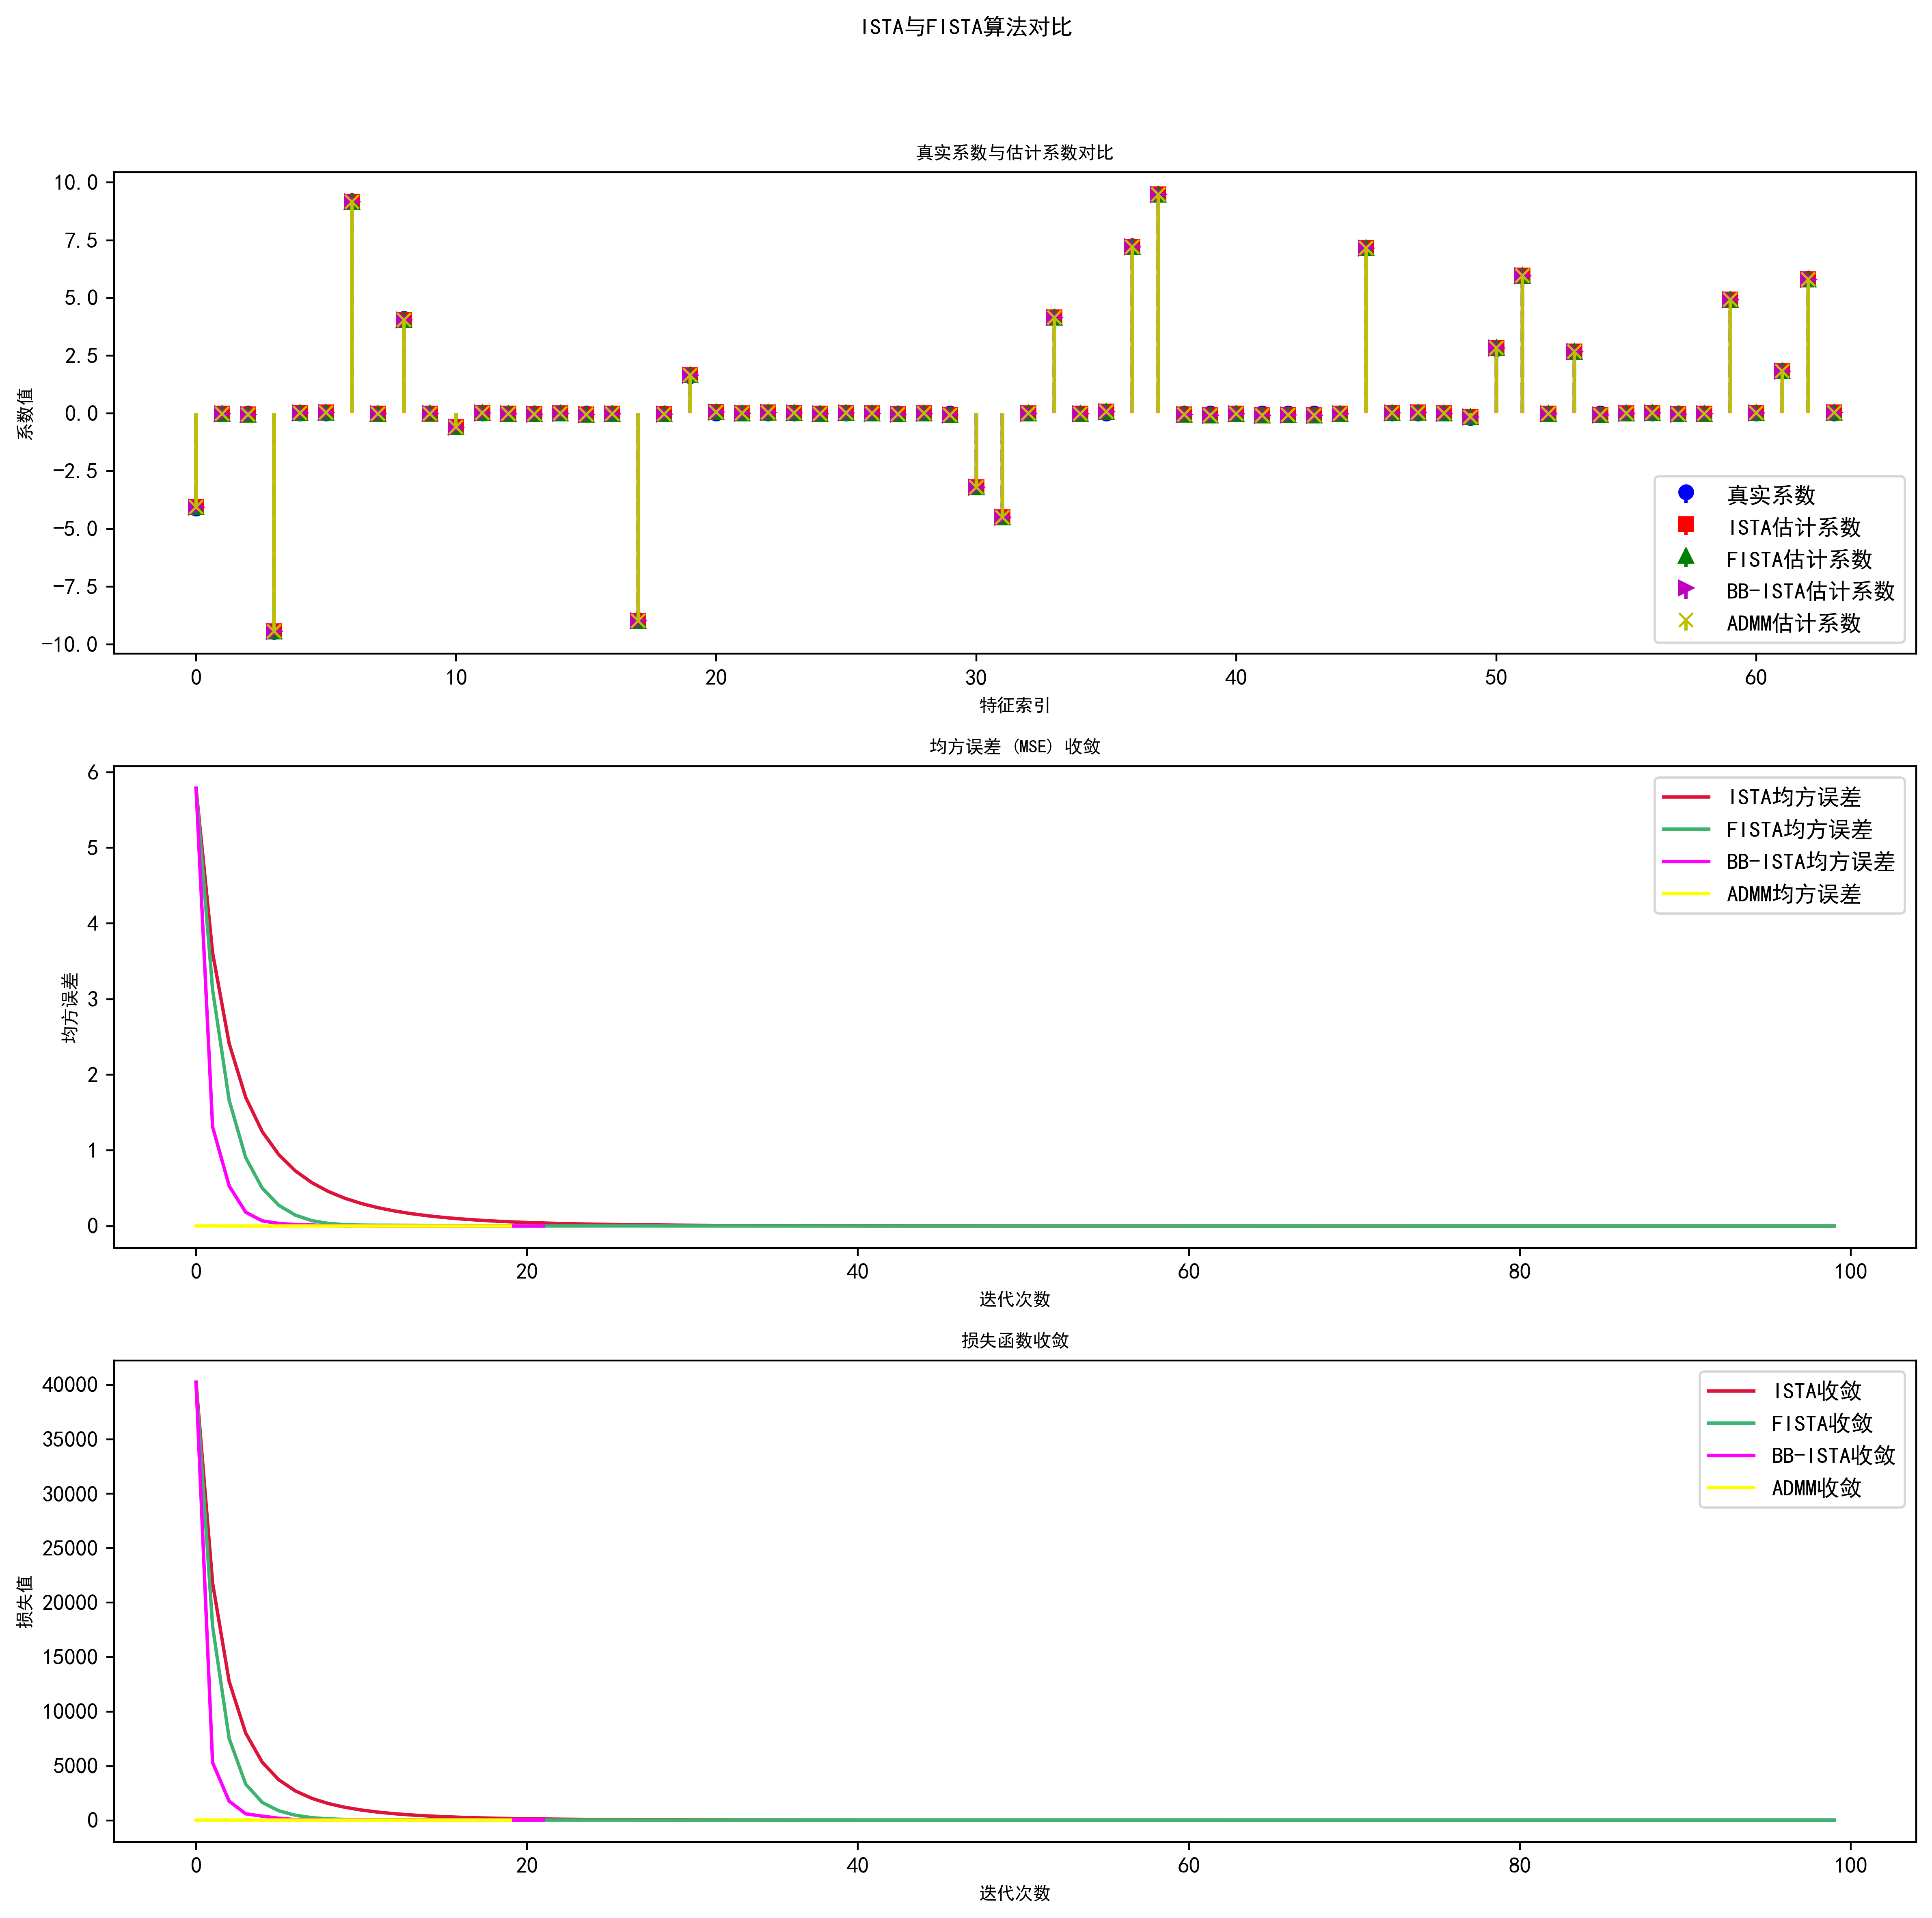

评价指标: 四种算法恢复真实稀疏信号的误差
ISTA恢复真实稀疏信号的误差 0.2808076427816751
FISTA恢复真实稀疏信号的误差 0.2800838895912364
BB-ISTA恢复真实稀疏信号的误差 0.27951859702296045
ADMM恢复真实稀疏信号的误差 0.2801833918828153


In [22]:
n_samples, n_features, sparsity, noise_level= 256, 64, 20, 0.5
lambda_, mu = 0.1, 0.001
A, b, true_coef = generate_data(n_samples, n_features, sparsity,noise_level)
x_ista, cost_history_ista, mse_history_ista = ista(A, b, lambda_, mu)
x_fista, cost_history_fista, mse_history_fista = fista(A, b, lambda_, mu)
x_BBista, cost_history_BBista, mse_history_BBista = BBista(A, b, lambda_, mu)
x_admm, cost_history_admm, mse_history_admm = admm_lasso(A, b,lambda_)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('ISTA与FISTA算法对比', fontsize=10, weight='bold')

axs[0].stem(true_coef, linefmt='b-', markerfmt='bo', basefmt=' ', label='真实系数')
axs[0].stem(x_ista, linefmt='r--', markerfmt='rs', basefmt=' ', label='ISTA估计系数')
axs[0].stem(x_fista, linefmt='g-.', markerfmt='g^', basefmt=' ', label='FISTA估计系数')
axs[0].stem(x_BBista, linefmt='m--', markerfmt='m>', basefmt=' ', label='BB-ISTA估计系数')
axs[0].stem(x_admm, linefmt='y-', markerfmt='yx', basefmt=' ', label='ADMM估计系数')
axs[0].legend()
axs[0].set_title('真实系数与估计系数对比', fontsize=8)
axs[0].set_xlabel('特征索引', fontsize=8)
axs[0].set_ylabel('系数值', fontsize=8)

axs[1].plot(mse_history_ista, color='crimson', linestyle='-', label='ISTA均方误差')
axs[1].plot(mse_history_fista, color='mediumseagreen', linestyle='-', label='FISTA均方误差')
axs[1].plot(mse_history_BBista, color='magenta', linestyle='-', label='BB-ISTA均方误差')
axs[1].plot(mse_history_admm, color='yellow', linestyle='-', label='ADMM均方误差')
axs[1].legend()
axs[1].set_title('均方误差 (MSE) 收敛', fontsize=8)
axs[1].set_xlabel('迭代次数', fontsize=8)
axs[1].set_ylabel('均方误差', fontsize=8)

axs[2].plot(cost_history_ista, color='crimson', linestyle='-', label='ISTA收敛')
axs[2].plot(cost_history_fista, color='mediumseagreen', linestyle='-', label='FISTA收敛')
axs[2].plot(cost_history_BBista, color='magenta', linestyle='-', label='BB-ISTA收敛')
axs[2].plot(cost_history_admm, color='yellow', linestyle='-', label='ADMM收敛')
axs[2].legend()
axs[2].set_title('损失函数收敛', fontsize=8)
axs[2].set_xlabel('迭代次数', fontsize=8)
axs[2].set_ylabel('损失值', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print('评价指标: 四种算法恢复真实稀疏信号的误差')
print('ISTA恢复真实稀疏信号的误差',np.linalg.norm(true_coef-x_ista))
print('FISTA恢复真实稀疏信号的误差',np.linalg.norm(true_coef-x_fista))
print('BB-ISTA恢复真实稀疏信号的误差',np.linalg.norm(true_coef-x_BBista))
print('ADMM恢复真实稀疏信号的误差',np.linalg.norm(true_coef-x_admm))

# 6 练习

1. 以第一个算法ISTA来求解LASSO问题，通过调整参数，来比较恢复真实稀疏信号的误差，误差越低越好。

# 7  拓展：LASSO算法的分类

目前已知的LASSO问题求解算法可以大致分为如下三类

1. 梯度类算法

文献: 刘浩洋, 户将, 李勇锋，文再文，最优化：建模、算法与理论, 高教出版社, 2020, (6.3.5) 和算法8.11

LASSO 问题求解: http://faculty.bicmr.pku.edu.cn/~wenzw/optbook/pages/contents/contents.html#5

1.1 次梯度法 
$$
x^{k+1}=x^{k}-\mu (A^T(Ax^k-b) + \lambda sign(x^k))
$$

1.2 分块坐标下降法

2. 邻近算法

文献： 叶颀, 谭露琳, 刘春光, 林荣荣，陈艳楠, 胡耀华.《最优化方法与机器学习》, 科学出版社“十四五”普通高等教育规划教材, 2025，第5.2.4节

2.1 ISTA/Proximal Gradient Algorithm

2.2 FISTA

2.3 BB-ISTA

2.4 ADMM

2.5 Dual-ADMM

3. 神经网络算法（配置环境如PyTorch稍微麻烦，训练时间时间相对较长）

文献：Chen X, Liu J, Yin W. Learning to optimize: A tutorial for continuous and mixed-integer optimization[J]. Science China Mathematics, 2024, 67(6): 1191-1262. Section 3: Algorithm unrolling

3.1 Learned ISTA (LISTA)

$$
x^{k+1}=prox_{\theta^k \|\cdot\|_1}(W^k x^k+U^k b)
$$

https://gist.github.com/nirshlezinger1/7cf8528f22709fb44fc5e13731758c48

https://github.com/kartheekkumar65/LISTA

3.2 Adaptive LISTA (Ada-LISTA)

https://github.com/aaberdam/AdaLISTA

3.3 LISTA-CP

https://github.com/VITA-Group/LISTA-CPSS

3.4  Step-LISTA

https://github.com/tomMoral/adopty

3.5 Analytical LISTA (ALISTA)

https://github.com/VITA-Group/ALISTA